In [1]:
#importing necessary libraries

import object_detection
import wget
import os
import tensorflow as tf
import cv2 
import numpy as np
from matplotlib import pyplot as plt
import random

from google.protobuf import text_format


from object_detection.builders import model_builder
from object_detection.utils import config_util
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.protos import pipeline_pb2


## Configuration setup

In [2]:
#lets create some variables to hold important urls and names
my_custom_model= 'my_ssd_mobnet' 
pre_trained_model = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
pre_trained_model_url = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
tfrecord_file = 'generate_tfrecord.py'
label_map_file = 'label_map.pbtxt'

In [3]:
#lets create a dictionary to hold path to different folders
my_paths = {
    'root': os.path.join('ANPRS', 'root'),
    'scripts': os.path.join('ANPRS','scripts'),
    'api_model': os.path.join('ANPRS','models'),
    'annotations': os.path.join('ANPRS', 'root','annotations'),
    'images': os.path.join('ANPRS', 'root','images'),
    'models': os.path.join('ANPRS', 'root','models'),
    'pre_trained_models': os.path.join('ANPRS', 'root','pre-trained-models'),
    'checkpoints': os.path.join('ANPRS', 'root','models',my_custom_model), 
    'output_path': os.path.join('ANPRS', 'root','models',my_custom_model, 'export'), 
    'TFJS':os.path.join('ANPRS', 'root','models',my_custom_model, 'tfjsexport'), 
    'TFLITE':os.path.join('ANPRS', 'root','models',my_custom_model, 'tfliteexport'), 
    'PROTOC':os.path.join('ANPRS','protoc')
 }

In [4]:
protocs_paths = {
    # to set the pre built model configurations
    'config_file':os.path.join('ANPRS', 'root','models', my_custom_model, 'pipeline.config'),
    # TFRecord files are used to store train and validation sets
    'TFRecord_file': os.path.join(my_paths['scripts'], tfrecord_file), 
    # maps integers to each class label
    'labelmap_file': os.path.join(my_paths['annotations'], label_map_file)
}

### Downloading the pretrained model

In [ ]:
wget.download(pre_trained_model_url)
!move {pre_trained_model+'.tar.gz'} {my_paths['pre_trained_models']}
!cd {my_paths['pre_trained_models']} && tar -zxvf {pre_trained_model+'.tar.gz'}

<h3>Creating a label Map</h3>

In [5]:
label_dic = [{'name':'licence', 'id':1}]
with open(protocs_paths['labelmap_file'], 'w') as f:
    for label in label_dic:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label_dic[0]['name']))
        f.write('\tid:{}\n'.format(label_dic[0]['id']))
        f.write('}\n')

### Downloading generate_records scripts which converts train and test TFRecord files that can be used for training and validating.

In [ ]:
if not os.path.exists(protocs_paths['TFRecord_file']):
    !git clone https://github.com/nicknochnack/GenerateTFRecord {my_paths['scripts']}

### running generate_record scripts on train and test folders :<br> takes folder path and label map as parameters

In [ ]:
# to avoid error tweak the generate file as per xml annotations of data
!python {protocs_paths['TFRecord_file']} -x {os.path.join(my_paths['images'], 'train')} -l {protocs_paths['labelmap_file']} -o {os.path.join(my_paths['annotations'], 'train_tf.record')} 
!python {protocs_paths['TFRecord_file']} -x {os.path.join(my_paths['images'], 'test')} -l {protocs_paths['labelmap_file']} -o {os.path.join(my_paths['annotations'], 'test_tf.record')} 

In [ ]:
!copy {os.path.join(my_paths['pre_trained_models'],pre_trained_model , 'pipeline.config')} {os.path.join(my_paths['checkpoints'])}

### Accessing the pipeline_config file of the prebuilt model

In [ ]:
config_dic = config_util.get_configs_from_pipeline_file(protocs_paths['config_file'])

In [ ]:
config_dic

### Using pipeline_pb2 module to configure the pipeline_line configuration file a per our use case

In [6]:

pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
type(pipeline_config)

object_detection.protos.pipeline_pb2.TrainEvalPipelineConfig

In [ ]:
with tf.io.gfile.GFile(protocs_paths['config_file'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [ ]:
pipeline_config

In [ ]:
(pipeline_config)

### Tweaking different model parameters

In [ ]:
pipeline_config.model.ssd.num_classes = len(label_dic)
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(my_paths['pre_trained_models'], pre_trained_model, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= protocs_paths['labelmap_file']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(my_paths['annotations'], 'train_tf.record')]
pipeline_config.eval_input_reader[0].label_map_path = protocs_paths['labelmap_file']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(my_paths['annotations'], 'test_tf.record')]

### Writing changes to the configuration file

In [ ]:
config_message_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(protocs_paths['config_file'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_message_text)   

In [7]:
run_script= os.path.join(my_paths['api_model'], 'research', 'object_detection', 'model_main_tf2.py')

In [ ]:
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=10000".format(run_script, my_paths['checkpoints'],protocs_paths['config_file'])

### Command to train the model on our dataset

In [ ]:
# run this command on terminal to see loss and other measures at each step.
print(command)

### Loading the model

In [8]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(protocs_paths['config_file'])
print(configs['model'])
my_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=my_model)
ckpt.restore(os.path.join(my_paths['checkpoints'], 'ckpt-11')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = my_model.preprocess(image)
    prediction_dict = my_model.predict(image, shapes)
    detections = my_model.postprocess(prediction_dict, shapes)
    return detections

ssd {
  num_classes: 1
  image_resizer {
    fixed_shape_resizer {
      height: 320
      width: 320
    }
  }
  feature_extractor {
    type: "ssd_mobilenet_v2_fpn_keras"
    depth_multiplier: 1.0
    min_depth: 16
    conv_hyperparams {
      regularizer {
        l2_regularizer {
          weight: 3.9999998989515007e-05
        }
      }
      initializer {
        random_normal_initializer {
          mean: 0.0
          stddev: 0.009999999776482582
        }
      }
      activation: RELU_6
      batch_norm {
        decay: 0.996999979019165
        scale: true
        epsilon: 0.0010000000474974513
      }
    }
    use_depthwise: true
    override_base_feature_extractor_hyperparams: true
    fpn {
      min_level: 3
      max_level: 7
      additional_layer_depth: 128
    }
  }
  box_coder {
    faster_rcnn_box_coder {
      y_scale: 10.0
      x_scale: 10.0
      height_scale: 5.0
      width_scale: 5.0
    }
  }
  matcher {
    argmax_matcher {
      matched_threshold: 0.5
  

## Evaluating the model

In [ ]:
command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(run_script, my_paths['checkpoints'],protocs_paths['config_file'], my_paths['checkpoints'])


In [ ]:
print(command)

### Making predictions and visualizing results

#### Predicting plates in an image

In [9]:
%matplotlib inline
def predict_in_image(IMAGE_PATH):
    img = cv2.imread(IMAGE_PATH)
    image_np = np.array(img)
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections
    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
    label_id_offset = 1
    image_np_with_detections = image_np.copy()
    # using object detection api's visualization utils to manipulate our image
    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.5,
                agnostic_mode=False)
    
    plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
    plt.show()
    return (detections,image_np_with_detections)

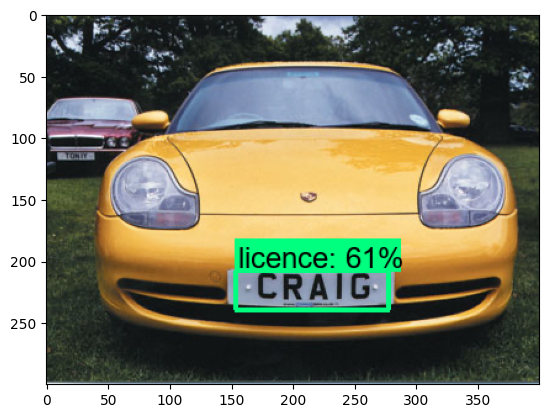

In [76]:
category_index = label_map_util.create_category_index_from_labelmap(protocs_paths['labelmap_file'])
# lets select a random image
k=random.sample(range(400,433),1)[0]
img_path = os.path.join(my_paths['images'],'test', 'cars{}.png'.format(k))
detections,image_np_with_detections=predict_in_image(img_path)

In [12]:
detections.keys()

dict_keys(['detection_boxes', 'detection_scores', 'detection_classes', 'raw_detection_boxes', 'raw_detection_scores', 'detection_multiclass_scores', 'detection_anchor_indices', 'num_detections'])

In [65]:
image_np_with_detections

array([[[155, 155, 155],
        [156, 156, 156],
        [158, 158, 158],
        ...,
        [102, 121, 112],
        [108, 127, 118],
        [109, 128, 119]],

       [[151, 151, 151],
        [152, 152, 152],
        [154, 154, 154],
        ...,
        [102, 121, 112],
        [104, 123, 114],
        [104, 123, 114]],

       [[140, 140, 140],
        [141, 141, 141],
        [143, 143, 143],
        ...,
        [109, 128, 119],
        [106, 125, 116],
        [101, 120, 111]],

       ...,

       [[ 91,  93,  87],
        [ 95,  97,  91],
        [104, 106, 100],
        ...,
        [ 97,  99,  93],
        [ 94,  96,  90],
        [ 89,  91,  85]],

       [[ 93,  94,  90],
        [ 93,  94,  90],
        [ 93,  94,  90],
        ...,
        [ 92,  93,  91],
        [ 91,  92,  90],
        [ 90,  91,  89]],

       [[ 97,  98,  94],
        [ 97,  98,  94],
        [ 97,  98,  94],
        ...,
        [ 98,  99,  97],
        [ 98,  99,  97],
        [ 94,  95,  93]]

In [13]:
detections['detection_boxes'],detections['detection_scores']

(array([[0.5623643 , 0.59580404, 0.636198  , 0.68622583],
        [0.606335  , 0.15498629, 0.6408748 , 0.22326636],
        [0.5950458 , 0.158831  , 0.6215309 , 0.219603  ],
        [0.6148576 , 0.164179  , 0.64162666, 0.21438792],
        [0.6154491 , 0.15342316, 0.6511617 , 0.2315341 ],
        [0.64809126, 0.16280106, 0.68333405, 0.21557194],
        [0.6092086 , 0.14553213, 0.65160894, 0.20896837],
        [0.6503782 , 0.18273036, 0.68345666, 0.22870643],
        [0.64819497, 0.14120215, 0.6879676 , 0.19443458],
        [0.5880682 , 0.        , 1.        , 1.        ],
        [0.5942433 , 0.167367  , 0.61619735, 0.21198611],
        [0.6211054 , 0.16059849, 0.66297776, 0.21943751],
        [0.61019695, 0.15064204, 0.6401179 , 0.19743928],
        [0.5563432 , 0.5717885 , 0.65343535, 0.6905287 ],
        [0.6565039 , 0.16646758, 0.69319975, 0.21289438],
        [0.67642885, 0.16934791, 0.70522374, 0.21563905],
        [0.67619944, 0.13713948, 0.7086859 , 0.19171657],
        [0.654

### 

#### Predicting plates in using webcam or a video

In [35]:
cap = cv2.VideoCapture(0)
if cap.isOpened():
    print("Webcam is available.")
else:
    print("Webcam is not available.")
cv2.waitKey(0)
cap.release()

Webcam is available.


In [38]:
%matplotlib inline
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while cap.isOpened(): 
    ret, frame = cap.read()
    image_np = np.array(frame)
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections
    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
    label_id_offset = 1
    image_np_with_detections = image_np.copy()
    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)
    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    if cv2.waitKey(0) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

<h1>OCR</h1>

## Importing easyocr library to perform optical character recognition

In [16]:
import easyocr

In [17]:
# to display results only if model confidence is above 50% about prediction
detection_threshold=0.5

In [18]:
# defining area threshold for extracting text
region_threshold = 0.05

In [66]:
def filter_text(region, ocr_result, region_threshold):
    rectangle_size = region.shape[0]*region.shape[1]
    plate = [] 
    for result in ocr_result:
        length = np.sum(np.subtract(result[0][1], result[0][0]))
        height = np.sum(np.subtract(result[0][2], result[0][1]))
        if length*height / rectangle_size > region_threshold:
            plate.append(result[1])
    return plate

In [77]:
def ocr_it(image, detections, detection_threshold, region_threshold):
    
    # Scores, boxes and classes above threhold
    scores = list(filter(lambda x: x> detection_threshold, detections['detection_scores']))
    boxes = detections['detection_boxes'][:len(scores)]
    classes = detections['detection_classes'][:len(scores)]
    
    # Full image dimensions
    width = image.shape[1]
    height = image.shape[0]
    
    # Apply ROI filtering and OCR
    for idx, box in enumerate(boxes):
        roi = box*[height, width, height, width]
        region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
        reader = easyocr.Reader(['en'])
        ocr_result = reader.readtext(region)
        
        text = filter_text(region, ocr_result, region_threshold)
        
        plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))
        plt.show()
        print(text)
        return list([text,region])


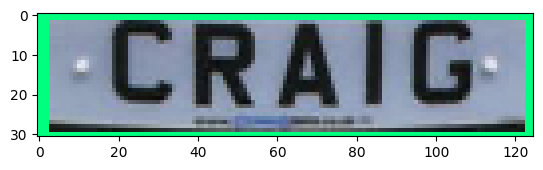

['CRAIG']


In [78]:
result = ocr_it(image_np_with_detections, detections, detection_threshold, region_threshold)